In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline

In [2]:
def fft_frequencies(sr=44100, n_fft=4096):
    return np.linspace(0,
                       float(sr) / 2,
                       int(1 + n_fft//2),
                       endpoint=True)

In [3]:
def new_spectral_contrast(y=None, sr=22050, S=None, n_fft=2048, hop_length=512,
                      freq=None, fmin=200.0, n_bands=6, quantile=0.02,
                      linear=False, arg1='mean', arg2='median'):
    if freq is None:
        freq = fft_frequencies(sr=sr, n_fft=n_fft)

    freq = np.atleast_1d(freq)

    if freq.ndim != 1 or len(freq) != S.shape[0]:
        raise ParameterError('freq.shape mismatch: expected '
                             '({:d},)'.format(S.shape[0]))

    if n_bands < 1 or not isinstance(n_bands, int):
        raise ParameterError('n_bands must be a positive integer')

    if not 0.0 < quantile < 1.0:
        raise ParameterError('quantile must lie in the range (0, 1)')

    if fmin <= 0:
        raise ParameterError('fmin must be a positive number')

    octa = np.zeros(n_bands + 2)
    octa[1:] = fmin * (2.0**np.arange(0, n_bands + 1))

    if np.any(octa[:-1] >= 0.5 * sr):
        raise ParameterError('Frequency band exceeds Nyquist. '
                             'Reduce either fmin or n_bands.')

    arg1m = np.zeros((n_bands + 1, S.shape[1]))
    arg2m = np.zeros_like(arg1m)
    
    for k, (f_low, f_high) in enumerate(zip(octa[:-1], octa[1:])):
    
        current_band = np.logical_and(freq >= f_low, freq <= f_high)
        idx = np.flatnonzero(current_band)    

        if k > 0:
            current_band[idx[0] - 1] = True
        if k == n_bands:
            current_band[idx[-1] + 1:] = True

        sub_band = S[current_band]

        if k < n_bands:
            sub_band = sub_band[:-1]

    #     idx = np.rint(quantile * np.sum(current_band))
    #     idx = int(np.maximum(idx, 1))

    #     sortedr = np.sort(sub_band, axis=0)
    #     valley[k] = np.mean(sortedr[:idx], axis=0)
    #     peak[k] = np.mean(sortedr[-idx:], axis=0)

        if arg1 == 'max':
            arg1m[k] = np.max(sub_band, axis=0)
        elif arg1 == 'mean':
            arg1m[k] = np.mean(sub_band, axis=0)
        elif arg1 == 'median':
            arg1m[k] = np.median(sub_band, axis=0)
        elif arg1 == 'mode':
            arg1m[k] = scipy.stats.mode(np.rint(sub_band), axis=0)[0]
    
        if arg2 == 'min':
            arg2m[k] = np.min(sub_band, axis=0)
        elif arg2 == 'mean':
            arg2m[k] = np.mean(sub_band, axis=0)
        elif arg2 == 'median':
            arg2m[k] = np.median(sub_band, axis=0)
        elif arg2 == 'mode':
            arg2m[k] = scipy.stats.mode(np.rint(sub_band), axis=0)[0]
    
    if linear:
        return arg1m - arg2m
    else:
        return librosa.power_to_db(arg1m, ref=np.max(S)) - librosa.power_to_db(arg2m, ref=np.max(S))

In [4]:
y, sr = librosa.load("../../../audio/paraensis.wav", sr=44100)
Y = librosa.stft(y, n_fft = 4096, hop_length = 512)
Y_dB = librosa.amplitude_to_db(Y, ref=np.max)

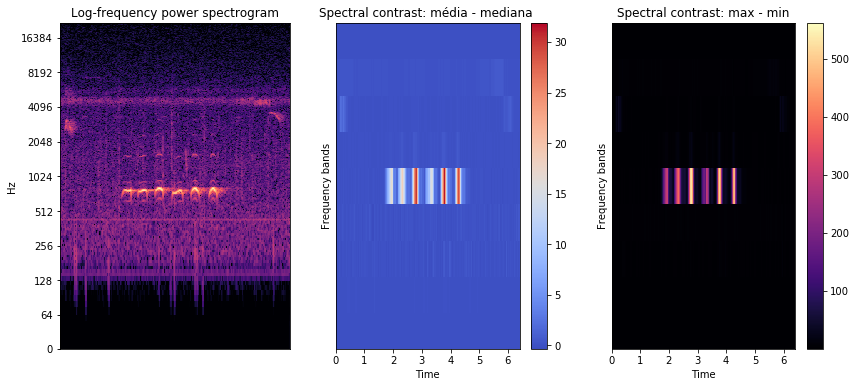

In [5]:
contrast = new_spectral_contrast(S=np.abs(Y), sr=sr, linear=True, n_bands=8, fmin=64, n_fft=4096)

plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
librosa.display.specshow(Y_dB, y_axis='log', sr=sr, hop_length = 512)
#plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

plt.subplot(1,3,2)
librosa.display.specshow(contrast, x_axis='time', sr=sr, hop_length = 512)
plt.ylabel('Frequency bands')
plt.colorbar()
plt.title('Spectral contrast: média - mediana ')

contrast = new_spectral_contrast(S=np.abs(Y), sr=sr, linear=True, n_bands=8, fmin=64, n_fft=4096, arg1='max', arg2='min')

plt.subplot(1,3,3)
librosa.display.specshow(contrast, x_axis='time', sr=sr, hop_length = 512)
plt.ylabel('Frequency bands')
plt.colorbar()
plt.title('Spectral contrast: max - min')

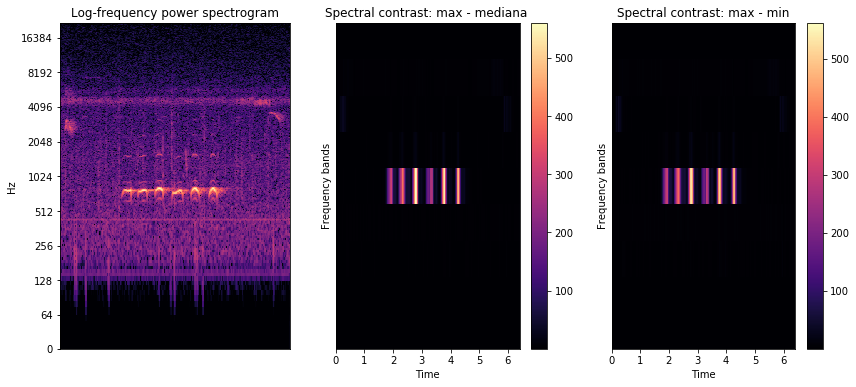

In [6]:
contrast = new_spectral_contrast(S=np.abs(Y), sr=sr, linear=True, n_bands=8, fmin=64, n_fft=4096, arg1='max', arg2='median')

plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
librosa.display.specshow(Y_dB, y_axis='log', sr=sr, hop_length = 512)
#plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

plt.subplot(1,3,2)
librosa.display.specshow(contrast, x_axis='time', sr=sr, hop_length = 512)
plt.ylabel('Frequency bands')
plt.colorbar()
plt.title('Spectral contrast: max - mediana ')

contrast = new_spectral_contrast(S=np.abs(Y), sr=sr, linear=True, n_bands=8, fmin=64, n_fft=4096, arg1='max', arg2='min')

plt.subplot(1,3,3)
librosa.display.specshow(contrast, x_axis='time', sr=sr, hop_length = 512)
plt.ylabel('Frequency bands')
plt.colorbar()
plt.title('Spectral contrast: max - min')

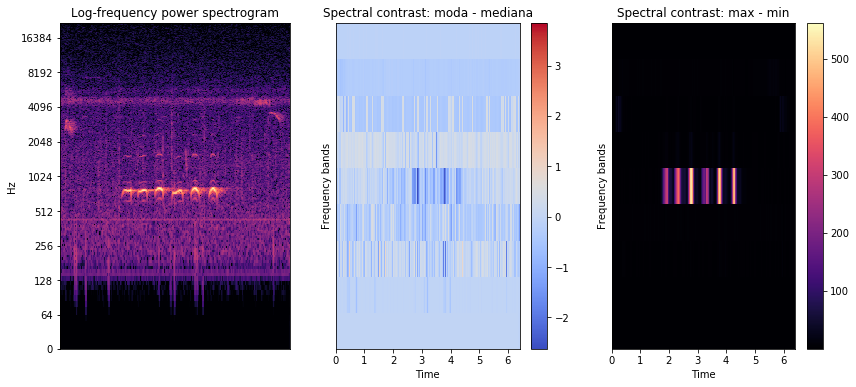

In [7]:
contrast = new_spectral_contrast(S=np.abs(Y), sr=sr, linear=True, n_bands=8, fmin=64, n_fft=4096, arg1='mode', arg2='median')

plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
librosa.display.specshow(Y_dB, y_axis='log', sr=sr, hop_length = 512)
#plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

plt.subplot(1,3,2)
librosa.display.specshow(contrast, x_axis='time', sr=sr, hop_length = 512)
plt.ylabel('Frequency bands')
plt.colorbar()
plt.title('Spectral contrast: moda - mediana')

contrast = new_spectral_contrast(S=np.abs(Y), sr=sr, linear=True, n_bands=8, fmin=64, n_fft=4096, arg1='max', arg2='min')

plt.subplot(1,3,3)
librosa.display.specshow(contrast, x_axis='time', sr=sr, hop_length = 512)
plt.ylabel('Frequency bands')
plt.colorbar()
plt.title('Spectral contrast: max - min')

In [8]:
y, sr = librosa.load("../../../audio/whittakeri.wav", sr=44100)
Y = librosa.stft(y, n_fft = 4096, hop_length = 512)
Y_dB = librosa.amplitude_to_db(Y, ref=np.max)

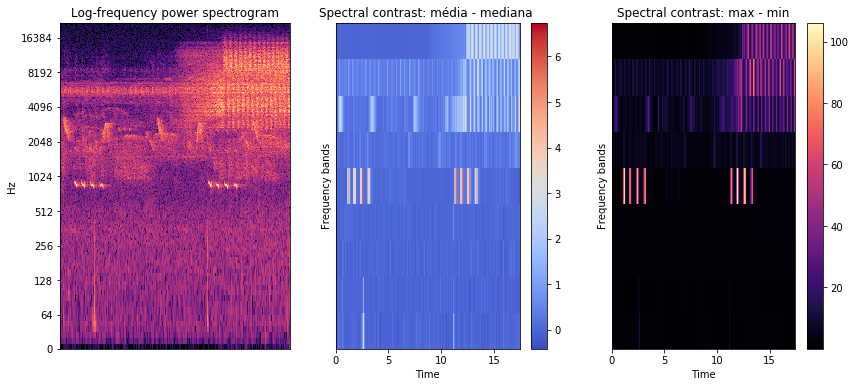

In [9]:
contrast = new_spectral_contrast(S=np.abs(Y), sr=sr, linear=True, n_bands=8, fmin=64, n_fft=4096)

plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
librosa.display.specshow(Y_dB, y_axis='log', sr=sr, hop_length = 512)
#plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

plt.subplot(1,3,2)
librosa.display.specshow(contrast, x_axis='time', sr=sr, hop_length = 512)
plt.ylabel('Frequency bands')
plt.colorbar()
plt.title('Spectral contrast: média - mediana ')

contrast = new_spectral_contrast(S=np.abs(Y), sr=sr, linear=True, n_bands=8, fmin=64, n_fft=4096, arg1='max', arg2='min')

plt.subplot(1,3,3)
librosa.display.specshow(contrast, x_axis='time', sr=sr, hop_length = 512)
plt.ylabel('Frequency bands')
plt.colorbar()
plt.title('Spectral contrast: max - min')

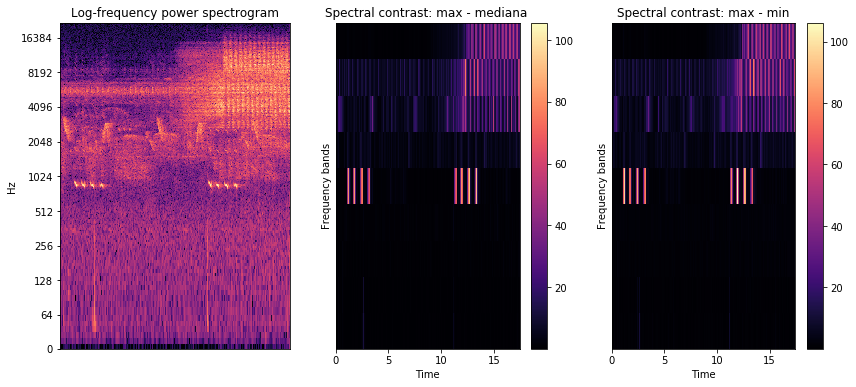

In [10]:
contrast = new_spectral_contrast(S=np.abs(Y), sr=sr, linear=True, n_bands=8, fmin=64, n_fft=4096, arg1='max', arg2='median')

plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
librosa.display.specshow(Y_dB, y_axis='log', sr=sr, hop_length = 512)
#plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

plt.subplot(1,3,2)
librosa.display.specshow(contrast, x_axis='time', sr=sr, hop_length = 512)
plt.ylabel('Frequency bands')
plt.colorbar()
plt.title('Spectral contrast: max - mediana ')

contrast = new_spectral_contrast(S=np.abs(Y), sr=sr, linear=True, n_bands=8, fmin=64, n_fft=4096, arg1='max', arg2='min')

plt.subplot(1,3,3)
librosa.display.specshow(contrast, x_axis='time', sr=sr, hop_length = 512)
plt.ylabel('Frequency bands')
plt.colorbar()
plt.title('Spectral contrast: max - min')

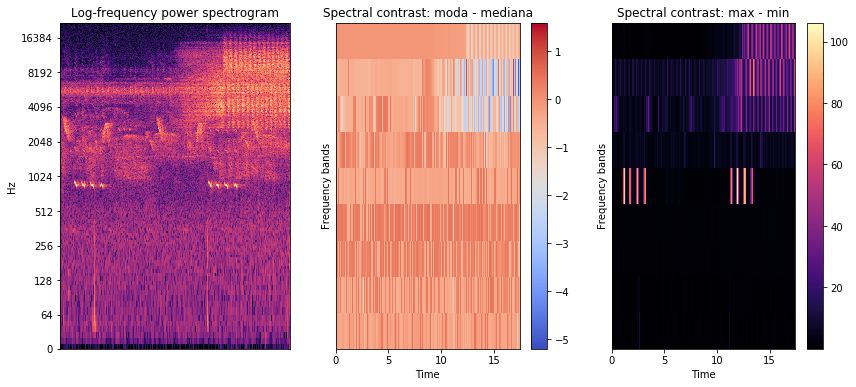

In [11]:
contrast = new_spectral_contrast(S=np.abs(Y), sr=sr, linear=True, n_bands=8, fmin=64, n_fft=4096, arg1='mode', arg2='median')

plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
librosa.display.specshow(Y_dB, y_axis='log', sr=sr, hop_length = 512)
#plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

plt.subplot(1,3,2)
librosa.display.specshow(contrast, x_axis='time', sr=sr, hop_length = 512)
plt.ylabel('Frequency bands')
plt.colorbar()
plt.title('Spectral contrast: moda - mediana')

contrast = new_spectral_contrast(S=np.abs(Y), sr=sr, linear=True, n_bands=8, fmin=64, n_fft=4096, arg1='max', arg2='min')

plt.subplot(1,3,3)
librosa.display.specshow(contrast, x_axis='time', sr=sr, hop_length = 512)
plt.ylabel('Frequency bands')
plt.colorbar()
plt.title('Spectral contrast: max - min')